<a href="https://colab.research.google.com/github/dsingaraju/generative_models/blob/main/gan_mnist_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

This is meant to provide a basic introduction to the mechanics of Generative Adversarial Networks (GANs). We train a GAN to generate images (size 28 x28) similar to the MNIST dataset. The network architectures are mostly based on this [Tensorflow tutorial](https://www.tensorflow.org/tutorials/generative/dcgan).  I was trying to learn Pytorch, and thought this to be an interesting problem to try.

**How to use the colab**
1. Connect to the runtime. For now, the code only supports CPU (plan to extend to GPU).
2. Run the following sections
   * _Imports_: Imports all relevant libraries.
   * _Load dataset_: Loads the MNIST dataset and visualizes a few examples.
   * _GANS_: Defines the generator and discriminator models. While the architectures are important in practice, pay specific attention to the section on training step since it shows (1) the losses for the discriminator and generator, and (2) how the model params are updated.

In [ ]:
#@title Imports
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import clear_output
from time import sleep

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import unittest

# Load dataset

In [ ]:
#@title Load train and test data.
root_dir = "tmp/data/"

train_data = datasets.MNIST(root=root_dir,
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())
test_data = datasets.MNIST(root=root_dir,
                           train=False,
                           download=True,
                           transform=transforms.ToTensor())

print('Training data size: ', len(train_data))
print('Test data size: ', len(test_data))

100%|██████████| 9912422/9912422 [00:00<00:00, 260434172.16it/s]

Extracting tmp/data/MNIST/raw/train-images-idx3-ubyte.gz to tmp/data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 22028676.82it/s]


Extracting tmp/data/MNIST/raw/train-labels-idx1-ubyte.gz to tmp/data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 112759711.68it/s]

Extracting tmp/data/MNIST/raw/t10k-images-idx3-ubyte.gz to tmp/data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 5806317.82it/s]


Extracting tmp/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to tmp/data/MNIST/raw

Training data size:  60000
Test data size:  10000


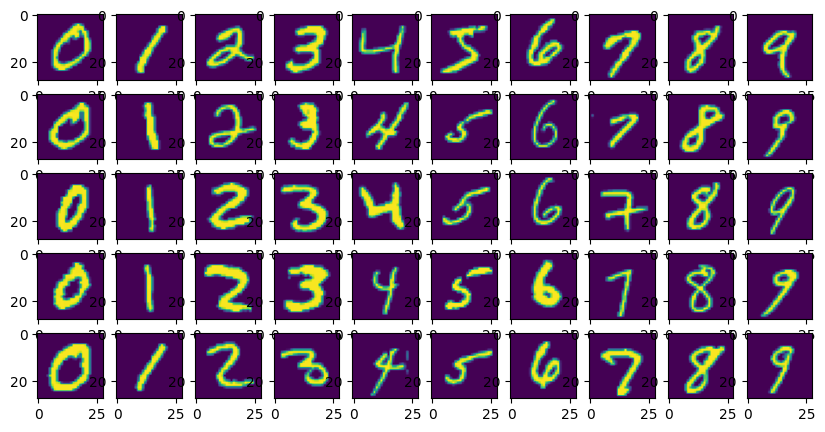

In [ ]:
#@title Visualize examples.
def visualize(dataset, num_per_label: int=5):
  labels = [dataset[i][1] for i in range(100)]
  _, ax = plt.subplots(num_per_label, 10, figsize=((10, num_per_label)))
  for l in range(10):
    ids = [i for i, label in enumerate(labels) if l == label]
    for i in range(min(num_per_label, len(ids))):
      img, _ = train_data[ids[i]]
      ax[i][l].imshow(img[0, : :])

visualize(train_data)


# GANs

Model architectures taken from the [Tensorflow tutorial](https://www.tensorflow.org/tutorials/generative/dcgan) on DCGANs.

In [ ]:
#@title Discriminator module
class GanDiscriminator(nn.Module):
  """ A ConvNet model trained to discriminate between real and generated images.

  The model is trained for binary classification.
  """
  def __init__(self):
    super().__init__()
    self._layers_stack = nn.Sequential(
        nn.LazyConv2d(out_channels=64, kernel_size=5,stride=2, padding=2),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.LazyConv2d(out_channels=128, kernel_size=5,stride=2,padding=2),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Flatten(),
        nn.LazyLinear(2),
        nn.Softmax())


  def forward(self, x):
    return self._layers_stack(x)

In [ ]:
#@title Generator module
class GanGenerator(nn.Module):
  def __init__(self):
    super().__init__()
    self._linear_project0 = nn.LazyLinear(7 * 7 * 256)
    self._layers_stack = nn.Sequential(
        nn.LazyConvTranspose2d(out_channels=128, kernel_size=5,
                               stride=1, padding=2),
        nn.ReLU(),
        nn.LazyConvTranspose2d(out_channels=64, kernel_size=5,
                               stride=2, padding=2,output_padding=1),
        nn.ReLU(),
        nn.LazyConvTranspose2d(out_channels=1, kernel_size=5,
                               stride=2, padding=2, output_padding=1),
    )

  def forward(self, x):
    output = self._linear_project0(x)
    output = torch.reshape(output, (x.size()[0], 256, 7, 7))
    output = self._layers_stack(output)
    return output


class GeneratorTest(unittest.TestCase):
  def test_generator_output_size(self):
    g = GanGenerator()
    z = torch.randn(10, 100)
    output = g.forward(z)
    np.testing.assert_equal(output.size(), [10, 1, 28, 28])

  def test_model_on_cuda(self):
    g = GanGenerator()
    if torch.cuda.is_available():
      g.to('cuda')
      z = torch.randn(10, 100).to('cuda')
      output = g.forward(z)
      np.testing.assert_equal(output.size(), [10, 1, 28, 28])

unittest.main(argv=[''], verbosity=2, exit=False,
              defaultTest=['GeneratorTest'])

test_generator_output_size (__main__.GeneratorTest) ... /usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
ok
test_model_on_cuda (__main__.GeneratorTest) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.045s

OK


In [ ]:
#@title Viz helper
def visualize_images(data: torch.Tensor, nplots: tuple[int, int], ax):
  nrows, ncols = nplots
  if ax is None:
    _, ax = plt.subplots(nrows, ncols, figsize=(ncols, nrows))
  d = data.detach()
  i = 0
  for r in range(nrows):
    for c in range(ncols):
      ax[r][c].imshow(d[i, 0, : ,:])
      i += 1
  sleep(0.1)

In [ ]:
#@title Training specification
disc = GanDiscriminator()
discriminator_loss = nn.CrossEntropyLoss()
disc_optimizer = torch.optim.Adam(disc.parameters(), betas=(1e-3, 0.98))

#@markdown Training batch params
batch_size = 64 #@param
train_dataloader = DataLoader(train_data, batch_size=batch_size)

#@markdown Generator params
latent_var_dim = 100 #@param

gen = GanGenerator()
gen_optimizer = torch.optim.Adam(gen.parameters(), betas=(1e-3, 0.98))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
#@title Training iterations
#@markdown You should expect to see somewhat recognizable numbers at the
#@markdown end of 1 epoch. Each epoch takes roughly 8 min.
def visualize_images(data: torch.Tensor, nplots: tuple[int, int], ax):
  nrows, ncols = nplots
  if ax is None:
    _, ax = plt.subplots(nrows, ncols, figsize=(ncols, nrows))
  d = data.detach()
  i = 0
  for r in range(nrows):
    for c in range(ncols):
      ax[r][c].imshow(d[i, 0, : ,:])
      i += 1

#@markdown Training params
gen_batch_size = 64 #@param
num_epochs = 10 #@param

#@markdown Visualization params
nrows = 3 #@param
ncols = 10 #@param


for e in range(num_epochs):
  for i, (data, _) in enumerate(train_dataloader):
    # Samples latent variables from a Normal dist.
    sample_z = torch.randn(
        size=(gen_batch_size, latent_var_dim), requires_grad=True)
    # Generates images by running the generator.
    gen_im = gen(sample_z)

    # Computes the generator loss and applies backprop.
    gen_loss = torch.mean(-torch.log(disc(gen_im)[:, 0]))
    gen_optimizer.zero_grad()
    gen_loss.backward()
    gen_optimizer.step()

    # Computes discriminator loss and applies backprop.
    real_im_disc_loss = torch.mean(
       -torch.log(disc(data)[:, 0]))
    # We don't want to compute gradients for the generator
    gen_im_disc_loss = torch.mean(
       -torch.log(disc(gen_im.detach())[:, 1]))
    disc_loss = real_im_disc_loss + gen_im_disc_loss
    disc_optimizer.zero_grad()
    disc_loss.backward()
    disc_optimizer.step()
    if i % 250 == 0:
      print('*** Epoch %d, Step %d ***' %(e,i))
      print('Generator loss: ',
            gen_loss.detach().numpy())
      print('Discriminator loss: ',
            disc_loss.detach().numpy())
      _, ax = plt.subplots(nrows, ncols, figsize=(ncols, nrows))
      visualize_images(gen_im, (nrows, ncols), ax)
      plt.show()
      sleep(1)
      clear_output(wait=True)

KeyboardInterrupt: ignored

# Appendix


In [ ]:
#@title Understanding input -> output size for deconvolution layers.
#@markdown Trying to understand what is the size of the output after applying
#@markdown "_deconvolution_".
kernel_size=5 #@param
size_in=4 #@param
stride=2 #@param

#@markdown Odd sized kernel
#@markdown If input size is odd, output size is odd, irrespective of stride.
#@markdown If input size is even, output size is odd only if stride is even.
kw = 0.5*(kernel_size-1)
size_out = 2*kw + 1 + stride * (size_in-1)
print(size_out)


# Test possible discriminator architectures.

**You can skip this section. It's not needed for GANs.**

The goal here is to evaluate the accuracy of a CNN architecture, i.e., is it good enough for training the generator. We'll train a model to predict 10 logits, which is different from what we'll do later - two class problem of real vs. generated.

In [ ]:
#@title Defines a CNN-based classifier. The model outputs 10-D logits for each class.
class CnnDigitClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.LazyConv2d(out_channels=5, kernel_size=5),
            nn.ReLU(),
            nn.LazyConv2d(out_channels=4, kernel_size=3),
            nn.ReLU(),
            nn.LazyConv2d(out_channels=3, kernel_size=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.LazyLinear(10)
            )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
#@title Train the classifier for a few epochs and test accuracy (~3m for 10 epochs).

num_epochs = 10 #@param
batch_size = 64 #@param

m = CnnDigitClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(m.parameters(), betas=(1e-3, 0.98))

train_dataloader = DataLoader(train_data, batch_size=batch_size)
m.train()
for e in range(num_epochs):
  print('=== Epoch #', e)
  for i, (data, labels) in enumerate(train_dataloader):
    pred = m(data)
    loss = loss_fn(pred, labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  print('Step %d: Loss = %.4f' % (i, loss) )



In [ ]:
#@title Evaluates the classifier on the test set.
test_dataloader = DataLoader(test_data, batch_size=64)
num_data = 0
num_correct = 0
m.eval()
with torch.no_grad():
  for i, (data, gt) in enumerate(test_dataloader):
    pred = m.forward(data)
    num_correct += (pred.argmax(1) == gt).type(torch.float).sum().item()
    num_data += len(gt)

acc = 100.* num_correct / num_data
print('# test data: ', num_data)
print('# correct: %d (%.2f%%)' % (num_correct, acc))